<a href="https://colab.research.google.com/github/OseiasBeu/fight_project/blob/main/Baseline_models_UFC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregamento das bibliotecas e leitura do dataset de treino:

In [38]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # desabilitar GPU
from tqdm import tqdm # Barra de progresso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Processamento / Validação
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# keras/tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

# Modelos
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


# Métricas
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# Constantes para replicabilidade
SEED = 111 
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


  0%|          | 0/245 [00:21<?, ?it/s]


In [39]:
df_ufc = pd.read_csv('https://raw.githubusercontent.com/OseiasBeu/fight_project/main/datasets/UFC_TREINO.csv')

# Separação do dataset em treino e teste:

In [40]:
X = df_ufc.drop(["date","Winner","B_fighter","R_fighter"], axis=1).values
y = df_ufc["Winner"].values
X_TREINO, X_VAL, y_TREINO, y_VAL = train_test_split(X,y, test_size=0.20, random_state=SEED)

# Algoritimo dummy:

Sempre prever 0 (vermelho)

In [41]:
metrics.accuracy_score(np.zeros(len(df_ufc.index)), df_ufc['Winner'])

0.5829210582921058

# Aplicação de modelos de ML:

## DNN:

### Deixando as features na mesma escala

In [42]:
scaler = MinMaxScaler()
scaler.fit(X_TREINO)
X_treino_scaled = scaler.transform(X_TREINO)
X_val_scaled = scaler.transform(X_VAL)

print(f"X_train_scaled shape: {X_treino_scaled.shape} | X_val_scaled shape: {X_val_scaled.shape} | y_train shape: {y_TREINO.shape} | y_val shape: {y_VAL.shape}")

X_train_scaled shape: (3719, 42) | X_val_scaled shape: (930, 42) | y_train shape: (3719,) | y_val shape: (930,)


### Criando o modelo:

In [43]:
# Instância do modelo
dnnClf = Sequential()

In [44]:
# Primeira camada oculta
dnnClf.add(Dense(units=20,input_dim=42,activation='relu'))

In [45]:

dnnClf.add(Dense(units=10,activation='relu'))
dnnClf.add(Dropout(0.5))

# Saída da camada

dnnClf.add(Dense(units=1, activation='sigmoid'))
dnnClf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping # evita divergência de perda e perda na validação
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=16)

Epoch 1/400
117/117 [==============================] - 1s 4ms/step - loss: 0.6918 - accuracy: 0.5469 - val_loss: 0.6783 - val_accuracy: 0.5957
Epoch 2/400
117/117 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5838 - val_loss: 0.6717 - val_accuracy: 0.5978
Epoch 3/400
117/117 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5886 - val_loss: 0.6713 - val_accuracy: 0.5989
Epoch 4/400
117/117 [==============================] - 0s 3ms/step - loss: 0.6713 - accuracy: 0.5881 - val_loss: 0.6738 - val_accuracy: 0.6043
Epoch 5/400
117/117 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.5932 - val_loss: 0.6686 - val_accuracy: 0.6054
Epoch 6/400
117/117 [==============================] - 0s 2ms/step - loss: 0.6691 - accuracy: 0.5996 - val_loss: 0.6696 - val_accuracy: 0.6011
Epoch 7/400
117/117 [==============================] - 0s 4ms/step - loss: 0.6666 - accuracy: 0.6023 - val_loss: 0.6669 - val_accuracy: 0.6011

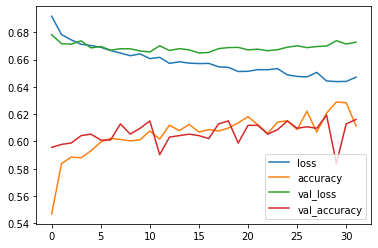

In [46]:
dnnClf.fit(
    x=X_treino_scaled,
    y=y_TREINO,
    epochs=400,
    validation_data =(X_val_scaled,y_VAL),
    verbose =1,
    callbacks=[early_stop]
)

model_loss = pd.DataFrame(dnnClf.history.history)
model_loss.plot()

In [47]:
dnnPreds = dnnClf.predict(scaler.transform(X_VAL))
dnnPreds = [round(i[0]) for i in dnnPreds]
target_names = ['class 0', 'class 1']
print("Desempenho de validação DNN em DESBALANCEADO(!):\n------------------\n",classification_report(y_VAL, dnnPreds , target_names=target_names))
print("AUC: ",roc_auc_score(y_VAL, dnnPreds))

30/30 [==============================] - 0s 1ms/step
Desempenho de validação DNN em DESBALANCEADO(!):
------------------
               precision    recall  f1-score   support

     class 0       0.62      0.89      0.74       555
     class 1       0.57      0.21      0.30       375

    accuracy                           0.62       930
   macro avg       0.60      0.55      0.52       930
weighted avg       0.60      0.62      0.56       930

AUC:  0.5495135135135135


## SVM:

In [48]:
svmClf = SVC(kernel='linear')
svmClf.fit(X_TREINO,y_TREINO)
svmPreds = svmClf.predict(X_VAL)

print("Desempenho de validação do modelo SVM em DESBALANCEADO(!):\n------------------\n",classification_report(y_VAL, svmPreds , target_names=target_names))
print("AUC: ",roc_auc_score(y_VAL, svmPreds))


Desempenho de validação do modelo SVM em DESBALANCEADO(!):
------------------
               precision    recall  f1-score   support

     class 0       0.62      0.85      0.72       555
     class 1       0.52      0.24      0.33       375

    accuracy                           0.60       930
   macro avg       0.57      0.54      0.52       930
weighted avg       0.58      0.60      0.56       930

AUC:  0.5438918918918919


## RandomForest: 

In [49]:
rfClf = RandomForestRegressor(n_estimators = 1000)
rfClf.fit(X_TREINO, y_TREINO)
rfPreds = rfClf.predict(X_VAL)
rfPreds = [round(i) for i in rfPreds]
print("Desempenho de validação do modelo RF em  DESBALANCEADO(!):\n------------------\n",classification_report(y_VAL, rfPreds , target_names=target_names))
print("AUC: ",roc_auc_score(y_VAL, rfPreds))


Desempenho de validação do modelo RF em  DESBALANCEADO(!):
------------------
               precision    recall  f1-score   support

     class 0       0.62      0.78      0.69       555
     class 1       0.49      0.30      0.37       375

    accuracy                           0.59       930
   macro avg       0.55      0.54      0.53       930
weighted avg       0.57      0.59      0.57       930

AUC:  0.542990990990991


## XGB: 

In [50]:
xgbClf = XGBClassifier(n_estimators=200)
xgbClf.fit(X_TREINO, y_TREINO)
xgbPreds = xgbClf.predict(X_VAL)
print("Desempenho de validação do modelo XGB em DESBALANCEADO(!):\n------------------\n",classification_report(y_VAL, xgbPreds , target_names=target_names))
print("AUC: ",roc_auc_score(y_VAL, xgbPreds))

Desempenho de validação do modelo XGB em DESBALANCEADO(!):
------------------
               precision    recall  f1-score   support

     class 0       0.63      0.82      0.71       555
     class 1       0.51      0.29      0.37       375

    accuracy                           0.60       930
   macro avg       0.57      0.55      0.54       930
weighted avg       0.58      0.60      0.57       930

AUC:  0.5521081081081082


## Regressão Logistica:

In [51]:
lrClf = LogisticRegression(solver="newton-cg")
lrClf.fit(X_TREINO, y_TREINO)
lrPreds = lrClf.predict(X_VAL)
print("Desempenho de validação do modelo LogReg em DESBALANCEADO(!):\n------------------\n",classification_report(y_VAL, lrPreds , target_names=target_names))
print("AUC: ",roc_auc_score(y_VAL, lrPreds))

Desempenho de validação do modelo LogReg em DESBALANCEADO(!):
------------------
               precision    recall  f1-score   support

     class 0       0.62      0.81      0.71       555
     class 1       0.50      0.28      0.36       375

    accuracy                           0.60       930
   macro avg       0.56      0.55      0.53       930
weighted avg       0.57      0.60      0.57       930

AUC:  0.5454054054054053


# Método de conjunto com desempenho de validação:

In [52]:
def predictEnsemble(sample, models=0):
    """ 
    Prevê a saída de uma amostra agregando votos numéricos de modelos.
    Por padrão, models = 0 considera todos os modelos;
    Quando definido com outro valor numérico chama o modelo correspondente:
    1: dnn | 2: svm | 3: rf | 4: xgb | 5: lr
    """
    modelsDict = {
        # Dicionário de modelos preditivos:
        1:dnnClf.predict(scaler.transform(sample.reshape(1,-1))).tolist()[0][0],
        2:svmClf.predict(sample.reshape(1,-1)).tolist()[0],
        3:rfClf.predict(sample.reshape(1,-1)).tolist()[0],
        4:xgbClf.predict(sample.reshape(1,-1)).tolist()[0],
        5:lrClf.predict(sample.reshape(1,-1)).tolist()[0]
    }
    preds = []
    if models == 0: # Usa todos os modelos:
        [preds.append(model) for model in modelsDict.values()]
    else: # Usa um modelo específico
        for model_code in models:
            preds.append(modelsDict[model_code])

    #print(preds)
    preds = [round(i) for i in preds] # transforma a probabilidade em uma label (threshold 0.5)
    #print(preds)
    #print(max(set(preds), key=preds.count))
    return(max(set(preds), key=preds.count))


ensPreds = []
[ensPreds.append(predictEnsemble(sample, models=[3,4,5])) for sample in tqdm(X_VAL)]
print("\nDesempenho de validação de conjunto em DESBALANCEADO(!):\n------------------\n",classification_report(y_VAL, ensPreds , target_names=target_names))
print("AUC: ",roc_auc_score(y_VAL, ensPreds))

  0%|          | 0/930 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 1/930 [00:00<02:17,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 2/930 [00:00<02:18,  6.68it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 3/930 [00:00<02:29,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 4/930 [00:00<02:25,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 5/930 [00:00<02:18,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 6/930 [00:00<02:12,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 7/930 [00:01<02:16,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 8/930 [00:01<02:16,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 9/930 [00:01<02:11,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 10/930 [00:01<02:17,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 11/930 [00:01<02:14,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 12/930 [00:01<02:16,  6.72it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 13/930 [00:01<02:12,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 14/930 [00:02<02:12,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 15/930 [00:02<02:12,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 16/930 [00:02<02:13,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 17/930 [00:02<02:15,  6.75it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 18/930 [00:02<02:12,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 19/930 [00:02<02:11,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 20/930 [00:02<02:10,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 21/930 [00:03<02:13,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 22/930 [00:03<02:10,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 23/930 [00:03<02:07,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 24/930 [00:03<02:08,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 25/930 [00:03<02:18,  6.55it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 26/930 [00:03<02:15,  6.65it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 27/930 [00:03<02:12,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 28/930 [00:04<02:10,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 29/930 [00:04<02:08,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 30/930 [00:04<02:08,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 31/930 [00:04<02:11,  6.83it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 32/930 [00:04<02:11,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 33/930 [00:04<02:08,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 34/930 [00:05<02:21,  6.33it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 35/930 [00:05<02:18,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 36/930 [00:05<02:17,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 37/930 [00:05<02:17,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 38/930 [00:05<02:19,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 39/930 [00:05<02:18,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 40/930 [00:05<02:22,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 41/930 [00:06<02:16,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 42/930 [00:06<02:11,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 43/930 [00:06<02:07,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 44/930 [00:06<02:08,  6.91it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 45/930 [00:06<02:08,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 46/930 [00:06<02:07,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 47/930 [00:06<02:07,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 48/930 [00:07<02:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 49/930 [00:07<02:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 50/930 [00:07<02:02,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 51/930 [00:07<02:06,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 52/930 [00:07<02:04,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 53/930 [00:07<02:07,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 54/930 [00:07<02:03,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 55/930 [00:08<02:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 56/930 [00:08<02:05,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 57/930 [00:08<02:03,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 58/930 [00:08<02:07,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 59/930 [00:08<02:09,  6.70it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 60/930 [00:08<02:07,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 61/930 [00:08<02:04,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 62/930 [00:09<02:06,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 63/930 [00:09<02:03,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 64/930 [00:09<02:03,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 65/930 [00:09<03:04,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 66/930 [00:09<02:44,  5.24it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 67/930 [00:10<02:32,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 68/930 [00:10<02:23,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 69/930 [00:10<02:23,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 70/930 [00:10<02:16,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 71/930 [00:10<02:14,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 72/930 [00:10<02:12,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 73/930 [00:10<02:07,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 74/930 [00:11<02:00,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 75/930 [00:11<02:03,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 76/930 [00:11<02:01,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 77/930 [00:11<02:00,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 78/930 [00:11<02:04,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 79/930 [00:11<02:03,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 80/930 [00:11<02:03,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 81/930 [00:12<01:59,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 82/930 [00:12<01:59,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 83/930 [00:12<01:59,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 84/930 [00:12<02:00,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 85/930 [00:12<02:06,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 86/930 [00:12<02:05,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 87/930 [00:12<02:02,  6.88it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 88/930 [00:13<01:59,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 89/930 [00:13<02:02,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 90/930 [00:13<02:01,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 91/930 [00:13<01:58,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 92/930 [00:13<01:57,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 93/930 [00:13<01:59,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 94/930 [00:13<02:03,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 95/930 [00:14<02:02,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 96/930 [00:14<01:58,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 97/930 [00:14<01:58,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 98/930 [00:14<01:56,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 99/930 [00:14<01:57,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 100/930 [00:14<02:01,  6.85it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 101/930 [00:14<01:59,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 102/930 [00:15<01:57,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 103/930 [00:15<01:56,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 104/930 [00:15<01:56,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 105/930 [00:15<01:59,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 106/930 [00:15<01:59,  6.87it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 107/930 [00:15<02:01,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 108/930 [00:15<02:00,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 109/930 [00:16<01:58,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 110/930 [00:16<01:55,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 111/930 [00:16<01:56,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 112/930 [00:16<01:58,  6.89it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 113/930 [00:16<01:57,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 114/930 [00:16<02:01,  6.69it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 115/930 [00:16<02:00,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 116/930 [00:17<01:56,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 117/930 [00:17<01:54,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 118/930 [00:17<01:55,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 119/930 [00:17<01:55,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 120/930 [00:17<01:54,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 121/930 [00:17<01:56,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 122/930 [00:17<01:54,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 123/930 [00:18<01:56,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 124/930 [00:18<01:54,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 125/930 [00:18<01:53,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 126/930 [00:18<01:53,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 127/930 [00:18<01:53,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 128/930 [00:18<01:55,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 129/930 [00:18<01:53,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 130/930 [00:19<01:51,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 131/930 [00:19<01:52,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 132/930 [00:19<01:52,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 133/930 [00:19<01:54,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 134/930 [00:19<01:52,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 135/930 [00:19<01:57,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 136/930 [00:19<01:54,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 137/930 [00:20<01:53,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 138/930 [00:20<01:55,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 139/930 [00:20<01:55,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 140/930 [00:20<01:55,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 141/930 [00:20<01:54,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 142/930 [00:20<01:56,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 143/930 [00:20<01:53,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 144/930 [00:21<01:53,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 145/930 [00:21<01:52,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 146/930 [00:21<01:56,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 147/930 [00:21<01:57,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 148/930 [00:21<01:55,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 149/930 [00:21<01:56,  6.68it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 150/930 [00:22<01:55,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 151/930 [00:22<01:52,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 152/930 [00:22<01:55,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 153/930 [00:22<01:54,  6.77it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 154/930 [00:22<01:51,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 155/930 [00:22<01:52,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 156/930 [00:22<01:56,  6.64it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 157/930 [00:23<01:58,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 158/930 [00:23<01:54,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 159/930 [00:23<01:52,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 160/930 [00:23<01:53,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 161/930 [00:23<01:55,  6.64it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 162/930 [00:23<01:55,  6.65it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 163/930 [00:23<01:55,  6.65it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 164/930 [00:24<01:51,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 165/930 [00:24<01:51,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 166/930 [00:24<01:50,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 167/930 [00:24<01:51,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 168/930 [00:24<01:49,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 169/930 [00:24<01:50,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 170/930 [00:24<01:49,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 171/930 [00:25<01:48,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 172/930 [00:25<01:46,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 173/930 [00:25<01:53,  6.68it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 174/930 [00:25<01:52,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 175/930 [00:25<01:49,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 176/930 [00:25<01:50,  6.83it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 177/930 [00:25<01:50,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 178/930 [00:26<01:55,  6.51it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 179/930 [00:26<01:56,  6.44it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 180/930 [00:26<01:55,  6.52it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 181/930 [00:26<01:54,  6.56it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 182/930 [00:26<01:53,  6.58it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 183/930 [00:26<01:52,  6.65it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 184/930 [00:27<01:50,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 185/930 [00:27<01:48,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 186/930 [00:27<01:46,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 187/930 [00:27<01:45,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 188/930 [00:27<01:45,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 189/930 [00:27<01:45,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 190/930 [00:27<01:45,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 191/930 [00:28<01:47,  6.89it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 192/930 [00:28<01:48,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 193/930 [00:28<01:48,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 194/930 [00:28<01:55,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 195/930 [00:28<01:53,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 196/930 [00:28<01:52,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 197/930 [00:28<01:50,  6.64it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 198/930 [00:29<01:49,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 199/930 [00:29<01:47,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 200/930 [00:29<01:48,  6.72it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 201/930 [00:29<01:46,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 202/930 [00:29<01:45,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 203/930 [00:29<01:43,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 204/930 [00:29<01:46,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 205/930 [00:30<01:46,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 206/930 [00:30<01:46,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 207/930 [00:30<01:47,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 208/930 [00:30<01:44,  6.89it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 209/930 [00:30<01:44,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 210/930 [00:30<01:43,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 211/930 [00:30<01:44,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 212/930 [00:31<01:45,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 213/930 [00:31<01:46,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 214/930 [00:31<01:43,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 215/930 [00:31<01:46,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 216/930 [00:31<01:43,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 217/930 [00:31<01:45,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 218/930 [00:32<01:43,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 219/930 [00:32<02:27,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 220/930 [00:32<02:12,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 221/930 [00:32<02:04,  5.70it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 222/930 [00:32<01:59,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 223/930 [00:32<01:52,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 224/930 [00:33<01:53,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 225/930 [00:33<01:49,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 226/930 [00:33<01:48,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 227/930 [00:33<01:48,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 228/930 [00:33<01:46,  6.61it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 229/930 [00:33<01:46,  6.59it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 230/930 [00:33<01:42,  6.85it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 231/930 [00:34<01:45,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 232/930 [00:34<01:40,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 233/930 [00:34<01:41,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 234/930 [00:34<01:44,  6.66it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 235/930 [00:34<01:41,  6.83it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 236/930 [00:34<01:43,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 237/930 [00:35<01:41,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 238/930 [00:35<01:43,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 239/930 [00:35<01:41,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 240/930 [00:35<01:41,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 241/930 [00:35<01:41,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 242/930 [00:35<01:39,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 243/930 [00:35<01:42,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 244/930 [00:36<01:41,  6.78it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 245/930 [00:36<01:43,  6.62it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 246/930 [00:36<01:51,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 247/930 [00:36<01:51,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 248/930 [00:36<01:47,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 249/930 [00:36<01:45,  6.45it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 250/930 [00:36<01:42,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 251/930 [00:37<01:43,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 252/930 [00:37<01:39,  6.78it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 253/930 [00:37<01:42,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 254/930 [00:37<01:40,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 255/930 [00:37<01:39,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 256/930 [00:37<01:37,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 257/930 [00:38<01:36,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 258/930 [00:38<01:37,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 259/930 [00:38<01:37,  6.87it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 260/930 [00:38<01:39,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 261/930 [00:38<01:41,  6.61it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 262/930 [00:38<01:41,  6.60it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 263/930 [00:38<01:39,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 264/930 [00:39<01:37,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 265/930 [00:39<01:38,  6.76it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 266/930 [00:39<01:37,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 267/930 [00:39<01:40,  6.63it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 268/930 [00:39<01:38,  6.71it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 269/930 [00:39<01:38,  6.72it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 270/930 [00:39<01:40,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 271/930 [00:40<01:38,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 272/930 [00:40<01:38,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 273/930 [00:40<01:38,  6.69it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 274/930 [00:40<01:37,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 275/930 [00:40<01:37,  6.69it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 276/930 [00:40<01:36,  6.81it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 277/930 [00:41<01:36,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 278/930 [00:41<01:36,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 279/930 [00:41<01:45,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 280/930 [00:41<01:43,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 281/930 [00:41<01:42,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 282/930 [00:41<01:39,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 283/930 [00:41<01:38,  6.59it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 284/930 [00:42<01:36,  6.70it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 285/930 [00:42<01:36,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 286/930 [00:42<01:39,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 287/930 [00:42<01:39,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 288/930 [00:42<01:38,  6.50it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 289/930 [00:42<01:37,  6.57it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 290/930 [00:43<01:38,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 291/930 [00:43<01:36,  6.59it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 292/930 [00:43<01:38,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 293/930 [00:43<01:41,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 294/930 [00:43<01:37,  6.54it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 295/930 [00:43<01:38,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 296/930 [00:43<01:36,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 297/930 [00:44<01:36,  6.53it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 298/930 [00:44<01:34,  6.72it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 299/930 [00:44<01:36,  6.56it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 300/930 [00:44<01:36,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 301/930 [00:44<01:33,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 302/930 [00:44<01:34,  6.67it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 303/930 [00:44<01:33,  6.71it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 304/930 [00:45<01:34,  6.65it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 305/930 [00:45<01:34,  6.63it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 306/930 [00:45<01:37,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 307/930 [00:45<01:36,  6.45it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 308/930 [00:45<01:35,  6.49it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 309/930 [00:45<01:34,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 310/930 [00:46<01:34,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 311/930 [00:46<01:31,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 312/930 [00:46<01:32,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 313/930 [00:46<01:30,  6.82it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 314/930 [00:46<01:34,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 315/930 [00:46<01:34,  6.48it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 316/930 [00:46<01:37,  6.29it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 317/930 [00:47<01:38,  6.19it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 318/930 [00:47<01:34,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 319/930 [00:47<01:36,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 320/930 [00:47<01:33,  6.56it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 321/930 [00:47<01:31,  6.63it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 322/930 [00:47<01:28,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 323/930 [00:48<01:28,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 324/930 [00:48<01:28,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 325/930 [00:48<01:27,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 326/930 [00:48<01:31,  6.57it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 327/930 [00:48<01:32,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 328/930 [00:48<01:33,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 329/930 [00:48<01:32,  6.50it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 330/930 [00:49<01:30,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 331/930 [00:49<01:29,  6.69it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 332/930 [00:49<01:28,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 333/930 [00:49<01:27,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 334/930 [00:49<01:29,  6.63it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 335/930 [00:49<01:29,  6.62it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 336/930 [00:49<01:30,  6.60it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 337/930 [00:50<01:29,  6.65it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 338/930 [00:50<01:31,  6.47it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 339/930 [00:50<01:32,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 340/930 [00:50<01:31,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 341/930 [00:50<01:29,  6.59it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 342/930 [00:50<01:30,  6.53it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 343/930 [00:51<01:28,  6.65it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 344/930 [00:51<01:28,  6.64it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 345/930 [00:51<01:27,  6.66it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 346/930 [00:51<01:30,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 347/930 [00:51<01:29,  6.55it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 348/930 [00:51<01:30,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 349/930 [00:51<01:27,  6.60it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 350/930 [00:52<01:27,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 351/930 [00:52<01:25,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 352/930 [00:52<01:25,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 353/930 [00:52<01:27,  6.58it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 354/930 [00:52<01:26,  6.66it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 355/930 [00:52<01:26,  6.69it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 356/930 [00:53<01:25,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 357/930 [00:53<01:25,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 358/930 [00:53<01:23,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 359/930 [00:53<01:23,  6.84it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 360/930 [00:53<01:25,  6.63it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 361/930 [00:53<01:27,  6.52it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 362/930 [00:53<01:26,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 363/930 [00:54<01:25,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 364/930 [00:54<01:24,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 365/930 [00:54<01:23,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 366/930 [00:54<01:22,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 367/930 [00:54<01:23,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 368/930 [00:54<01:23,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 369/930 [00:54<01:25,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 370/930 [00:55<01:23,  6.67it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 371/930 [00:55<01:23,  6.72it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 372/930 [00:55<01:24,  6.57it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 373/930 [00:55<01:57,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 374/930 [00:55<01:46,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 375/930 [00:56<01:39,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 376/930 [00:56<01:33,  5.95it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 377/930 [00:56<01:28,  6.26it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 378/930 [00:56<01:28,  6.27it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 379/930 [00:56<01:31,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 380/930 [00:56<01:27,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 381/930 [00:56<01:26,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 382/930 [00:57<01:25,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 383/930 [00:57<01:25,  6.42it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 384/930 [00:57<01:25,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 385/930 [00:57<01:25,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 386/930 [00:57<01:25,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 387/930 [00:57<01:23,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 388/930 [00:58<01:23,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 389/930 [00:58<01:21,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 390/930 [00:58<01:22,  6.52it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 391/930 [00:58<01:20,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 392/930 [00:58<01:22,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 393/930 [00:58<01:21,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 394/930 [00:58<01:21,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 395/930 [00:59<01:20,  6.63it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 396/930 [00:59<01:20,  6.63it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 397/930 [00:59<01:20,  6.65it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 398/930 [00:59<01:20,  6.60it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 399/930 [00:59<01:22,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 400/930 [00:59<01:21,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 401/930 [01:00<01:21,  6.51it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 402/930 [01:00<01:19,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 403/930 [01:00<01:19,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 404/930 [01:00<01:17,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 405/930 [01:00<01:19,  6.59it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 406/930 [01:00<01:22,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 407/930 [01:00<01:19,  6.54it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 408/930 [01:01<01:19,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 409/930 [01:01<01:18,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 410/930 [01:01<01:18,  6.63it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 411/930 [01:01<01:19,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 412/930 [01:01<01:21,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 413/930 [01:01<01:19,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 414/930 [01:02<01:18,  6.60it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 415/930 [01:02<01:18,  6.60it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 416/930 [01:02<01:18,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 417/930 [01:02<01:19,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 418/930 [01:02<01:18,  6.53it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 419/930 [01:02<01:20,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 420/930 [01:02<01:18,  6.49it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 421/930 [01:03<01:17,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 422/930 [01:03<01:17,  6.53it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 423/930 [01:03<01:16,  6.60it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 424/930 [01:03<01:18,  6.48it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 425/930 [01:03<01:17,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 426/930 [01:03<01:17,  6.51it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 427/930 [01:04<01:16,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 428/930 [01:04<01:15,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 429/930 [01:04<01:14,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 430/930 [01:04<01:13,  6.77it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 431/930 [01:04<01:14,  6.70it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 432/930 [01:04<01:16,  6.54it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 433/930 [01:04<01:15,  6.55it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 434/930 [01:05<01:13,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 435/930 [01:05<01:14,  6.64it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 436/930 [01:05<01:13,  6.68it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 437/930 [01:05<01:14,  6.59it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 438/930 [01:05<01:13,  6.68it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 439/930 [01:05<01:18,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 440/930 [01:05<01:17,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 441/930 [01:06<01:17,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 442/930 [01:06<01:16,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 443/930 [01:06<01:17,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 444/930 [01:06<01:16,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 445/930 [01:06<01:16,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 446/930 [01:06<01:15,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 447/930 [01:07<01:15,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 448/930 [01:07<01:15,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 449/930 [01:07<01:13,  6.58it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 450/930 [01:07<01:15,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 451/930 [01:07<01:15,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 452/930 [01:07<01:15,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 453/930 [01:08<01:15,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 454/930 [01:08<01:13,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 455/930 [01:08<01:12,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 456/930 [01:08<01:14,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 457/930 [01:08<01:14,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 458/930 [01:08<01:15,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 459/930 [01:08<01:15,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 460/930 [01:09<01:15,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 461/930 [01:09<01:12,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 462/930 [01:09<01:13,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 463/930 [01:09<01:16,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 464/930 [01:09<01:16,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 465/930 [01:09<01:17,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 466/930 [01:10<01:14,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 467/930 [01:10<01:12,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 468/930 [01:10<01:12,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 469/930 [01:10<01:13,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 470/930 [01:10<01:11,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 471/930 [01:10<01:10,  6.54it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 472/930 [01:11<01:10,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 473/930 [01:11<01:09,  6.59it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 474/930 [01:11<01:11,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 475/930 [01:11<01:11,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 476/930 [01:11<01:09,  6.51it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 477/930 [01:11<01:11,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 478/930 [01:11<01:11,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 479/930 [01:12<01:09,  6.50it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 480/930 [01:12<01:10,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 481/930 [01:12<01:09,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 482/930 [01:12<01:08,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 483/930 [01:12<01:07,  6.60it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 484/930 [01:12<01:07,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 485/930 [01:13<01:08,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 486/930 [01:13<01:08,  6.52it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 487/930 [01:13<01:06,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 488/930 [01:13<01:05,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 489/930 [01:13<01:06,  6.62it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 490/930 [01:13<01:07,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 491/930 [01:13<01:06,  6.64it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 492/930 [01:14<01:08,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 493/930 [01:14<01:07,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 494/930 [01:14<01:05,  6.65it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 495/930 [01:14<01:06,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 496/930 [01:14<01:04,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 497/930 [01:14<01:05,  6.64it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 498/930 [01:15<01:05,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 499/930 [01:15<01:04,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 500/930 [01:15<01:05,  6.56it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 501/930 [01:15<01:04,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 502/930 [01:15<01:03,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 503/930 [01:15<01:04,  6.66it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 504/930 [01:15<01:03,  6.72it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 505/930 [01:16<01:03,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 506/930 [01:16<01:03,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 507/930 [01:16<01:03,  6.66it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 508/930 [01:16<01:02,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 509/930 [01:16<01:03,  6.67it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 510/930 [01:16<01:02,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 511/930 [01:16<01:01,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 512/930 [01:17<01:03,  6.57it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 513/930 [01:17<01:03,  6.54it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 514/930 [01:17<01:02,  6.63it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 515/930 [01:17<01:03,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 516/930 [01:17<01:01,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 517/930 [01:17<01:02,  6.63it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 518/930 [01:18<01:03,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 519/930 [01:18<01:03,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 520/930 [01:18<01:03,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 521/930 [01:18<01:02,  6.57it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 522/930 [01:18<01:02,  6.58it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 523/930 [01:18<01:01,  6.63it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 524/930 [01:18<01:01,  6.61it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 525/930 [01:19<01:00,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 526/930 [01:19<01:27,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 527/930 [01:19<01:18,  5.15it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 528/930 [01:19<01:13,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 529/930 [01:19<01:09,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 530/930 [01:20<01:07,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 531/930 [01:20<01:05,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 532/930 [01:20<01:05,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 533/930 [01:20<01:02,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 534/930 [01:20<01:01,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 535/930 [01:20<01:00,  6.48it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 536/930 [01:20<01:00,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 537/930 [01:21<00:59,  6.55it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 538/930 [01:21<01:02,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 539/930 [01:21<01:00,  6.50it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 540/930 [01:21<01:00,  6.49it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 541/930 [01:21<01:00,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 542/930 [01:21<01:00,  6.44it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 543/930 [01:22<00:58,  6.62it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 544/930 [01:22<00:57,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 545/930 [01:22<00:57,  6.69it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 546/930 [01:22<00:58,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 547/930 [01:22<00:58,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 548/930 [01:22<00:59,  6.47it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 549/930 [01:22<00:58,  6.57it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 550/930 [01:23<00:58,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 551/930 [01:23<00:58,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 552/930 [01:23<00:58,  6.49it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 553/930 [01:23<00:58,  6.50it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 554/930 [01:23<01:00,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 555/930 [01:23<00:59,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 556/930 [01:24<00:57,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 557/930 [01:24<00:57,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 558/930 [01:24<01:00,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 559/930 [01:24<00:58,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 560/930 [01:24<00:57,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 561/930 [01:24<00:56,  6.49it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 562/930 [01:25<00:57,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 563/930 [01:25<00:57,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 564/930 [01:25<00:59,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 565/930 [01:25<00:59,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 566/930 [01:25<00:58,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 567/930 [01:25<00:57,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 568/930 [01:25<00:56,  6.38it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 569/930 [01:26<00:55,  6.49it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 570/930 [01:26<00:56,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 571/930 [01:26<00:57,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 572/930 [01:26<00:56,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 573/930 [01:26<00:56,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 574/930 [01:26<00:56,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 575/930 [01:27<00:55,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 576/930 [01:27<00:53,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 577/930 [01:27<00:54,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 578/930 [01:27<00:58,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 579/930 [01:27<00:57,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 580/930 [01:27<00:55,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 581/930 [01:28<00:54,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 582/930 [01:28<00:54,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 583/930 [01:28<00:56,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 584/930 [01:28<00:58,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 585/930 [01:28<00:57,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 586/930 [01:28<00:55,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 587/930 [01:28<00:55,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 588/930 [01:29<00:53,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 589/930 [01:29<00:53,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 590/930 [01:29<00:54,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 591/930 [01:29<00:54,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 592/930 [01:29<00:55,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 593/930 [01:29<00:53,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 594/930 [01:30<00:53,  6.30it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 595/930 [01:30<00:52,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 596/930 [01:30<00:54,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 597/930 [01:30<00:53,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 598/930 [01:30<00:53,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 599/930 [01:30<00:52,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 600/930 [01:31<00:51,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 601/930 [01:31<00:52,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 602/930 [01:31<00:53,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 603/930 [01:31<00:53,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 604/930 [01:31<00:51,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 605/930 [01:31<00:51,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 606/930 [01:32<00:50,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 607/930 [01:32<00:50,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 608/930 [01:32<00:52,  6.12it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 609/930 [01:32<00:51,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 610/930 [01:32<00:50,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 611/930 [01:32<00:53,  5.91it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 612/930 [01:33<00:57,  5.49it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 613/930 [01:33<01:00,  5.21it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 614/930 [01:33<01:04,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 615/930 [01:33<01:07,  4.65it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 616/930 [01:33<01:07,  4.63it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 617/930 [01:34<01:09,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 618/930 [01:34<01:09,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 619/930 [01:34<01:09,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 620/930 [01:34<01:08,  4.52it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 621/930 [01:35<01:10,  4.39it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 622/930 [01:35<01:09,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 623/930 [01:35<01:08,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 624/930 [01:35<01:02,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 625/930 [01:35<00:58,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 626/930 [01:36<00:55,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 627/930 [01:36<00:53,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 628/930 [01:36<00:50,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 629/930 [01:36<00:49,  6.06it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 630/930 [01:36<00:49,  6.06it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 631/930 [01:36<00:48,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 632/930 [01:36<00:48,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 633/930 [01:37<00:47,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 634/930 [01:37<00:46,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 635/930 [01:37<00:45,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 636/930 [01:37<00:46,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 637/930 [01:37<00:47,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 638/930 [01:37<00:46,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 639/930 [01:38<00:45,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 640/930 [01:38<00:44,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 641/930 [01:38<00:45,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 642/930 [01:38<00:45,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 643/930 [01:38<00:47,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 644/930 [01:38<00:46,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 645/930 [01:39<00:45,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 646/930 [01:39<00:44,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 647/930 [01:39<00:44,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 648/930 [01:39<00:44,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 649/930 [01:39<00:44,  6.26it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 650/930 [01:39<00:44,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 651/930 [01:39<00:43,  6.39it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 652/930 [01:40<00:44,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 653/930 [01:40<00:42,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 654/930 [01:40<00:42,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 655/930 [01:40<00:42,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 656/930 [01:40<00:43,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 657/930 [01:40<00:42,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 658/930 [01:41<00:43,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 659/930 [01:41<00:42,  6.45it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 660/930 [01:41<00:41,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 661/930 [01:41<00:43,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 662/930 [01:41<00:42,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 663/930 [01:41<00:43,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 664/930 [01:42<00:42,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 665/930 [01:42<00:41,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 666/930 [01:42<00:41,  6.39it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 667/930 [01:42<00:41,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 668/930 [01:42<00:41,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 669/930 [01:42<00:42,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 670/930 [01:42<00:41,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 671/930 [01:43<00:40,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 672/930 [01:43<00:43,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 673/930 [01:43<00:43,  5.95it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 674/930 [01:43<00:42,  5.98it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 675/930 [01:43<00:43,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 676/930 [01:44<00:42,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 677/930 [01:44<00:41,  6.05it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 678/930 [01:44<00:41,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 679/930 [01:44<00:41,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 680/930 [01:44<00:40,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 681/930 [01:44<00:40,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 682/930 [01:44<00:40,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 683/930 [01:45<00:55,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 684/930 [01:45<00:49,  5.00it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 685/930 [01:45<00:46,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 686/930 [01:45<00:43,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 687/930 [01:45<00:42,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 688/930 [01:46<00:40,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 689/930 [01:46<00:39,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 690/930 [01:46<00:40,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 691/930 [01:46<00:39,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 692/930 [01:46<00:40,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 693/930 [01:46<00:39,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 694/930 [01:47<00:39,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 695/930 [01:47<00:38,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 696/930 [01:47<00:37,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 697/930 [01:47<00:37,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 698/930 [01:47<00:37,  6.22it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 699/930 [01:47<00:37,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 700/930 [01:48<00:37,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 701/930 [01:48<00:36,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 702/930 [01:48<00:36,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 703/930 [01:48<00:35,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 704/930 [01:48<00:35,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 705/930 [01:48<00:35,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 706/930 [01:49<00:35,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 707/930 [01:49<00:36,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 708/930 [01:49<00:35,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 709/930 [01:49<00:35,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 710/930 [01:49<00:35,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 711/930 [01:49<00:35,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 712/930 [01:49<00:35,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 713/930 [01:50<00:35,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 714/930 [01:50<00:34,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 715/930 [01:50<00:35,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 716/930 [01:50<00:35,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 717/930 [01:50<00:34,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 718/930 [01:50<00:34,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 719/930 [01:51<00:34,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 720/930 [01:51<00:33,  6.22it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 721/930 [01:51<00:33,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 722/930 [01:51<00:33,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 723/930 [01:51<00:33,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 724/930 [01:51<00:33,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 725/930 [01:52<00:33,  6.19it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 726/930 [01:52<00:33,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 727/930 [01:52<00:32,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 728/930 [01:52<00:32,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 729/930 [01:52<00:32,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 730/930 [01:52<00:31,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 731/930 [01:53<00:32,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 732/930 [01:53<00:31,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 733/930 [01:53<00:30,  6.42it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 734/930 [01:53<00:30,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 735/930 [01:53<00:30,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 736/930 [01:53<00:30,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 737/930 [01:53<00:29,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 738/930 [01:54<00:30,  6.22it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 739/930 [01:54<00:30,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 740/930 [01:54<00:29,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 741/930 [01:54<00:29,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 742/930 [01:54<00:29,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 743/930 [01:54<00:29,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 744/930 [01:55<00:29,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 745/930 [01:55<00:29,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 746/930 [01:55<00:28,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 747/930 [01:55<00:28,  6.51it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 748/930 [01:55<00:28,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 749/930 [01:55<00:28,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 750/930 [01:56<00:27,  6.57it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 751/930 [01:56<00:27,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 752/930 [01:56<00:27,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 753/930 [01:56<00:27,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 754/930 [01:56<00:27,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 755/930 [01:56<00:27,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 756/930 [01:56<00:27,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 757/930 [01:57<00:26,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 758/930 [01:57<00:26,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 759/930 [01:57<00:28,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 760/930 [01:57<00:27,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 761/930 [01:57<00:27,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 762/930 [01:57<00:27,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 763/930 [01:58<00:27,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 764/930 [01:58<00:26,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 765/930 [01:58<00:26,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 766/930 [01:58<00:25,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 767/930 [01:58<00:25,  6.30it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 768/930 [01:58<00:25,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 769/930 [01:59<00:25,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 770/930 [01:59<00:25,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 771/930 [01:59<00:25,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 772/930 [01:59<00:26,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 773/930 [01:59<00:25,  6.10it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 774/930 [01:59<00:25,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 775/930 [02:00<00:24,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 776/930 [02:00<00:24,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 777/930 [02:00<00:23,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 778/930 [02:00<00:23,  6.45it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 779/930 [02:00<00:23,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 780/930 [02:00<00:23,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 781/930 [02:00<00:22,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 782/930 [02:01<00:22,  6.57it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 783/930 [02:01<00:22,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 784/930 [02:01<00:22,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 785/930 [02:01<00:22,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 786/930 [02:01<00:22,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 787/930 [02:01<00:22,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 788/930 [02:02<00:21,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 789/930 [02:02<00:21,  6.50it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 790/930 [02:02<00:21,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 791/930 [02:02<00:21,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 792/930 [02:02<00:21,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 793/930 [02:02<00:21,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 794/930 [02:02<00:21,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 795/930 [02:03<00:20,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 796/930 [02:03<00:20,  6.49it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 797/930 [02:03<00:20,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 798/930 [02:03<00:20,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 799/930 [02:03<00:20,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 800/930 [02:03<00:20,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 801/930 [02:04<00:19,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 802/930 [02:04<00:19,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 803/930 [02:04<00:19,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 804/930 [02:04<00:19,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 805/930 [02:04<00:19,  6.48it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 806/930 [02:04<00:19,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 807/930 [02:05<00:19,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 808/930 [02:05<00:18,  6.44it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 809/930 [02:05<00:18,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 810/930 [02:05<00:19,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 811/930 [02:05<00:18,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 812/930 [02:05<00:18,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 813/930 [02:05<00:18,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 814/930 [02:06<00:18,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 815/930 [02:06<00:17,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 816/930 [02:06<00:18,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 817/930 [02:06<00:18,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 818/930 [02:06<00:17,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 819/930 [02:06<00:17,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 820/930 [02:07<00:17,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 821/930 [02:07<00:16,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 822/930 [02:07<00:16,  6.50it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 823/930 [02:07<00:17,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 824/930 [02:07<00:17,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 825/930 [02:07<00:16,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 826/930 [02:08<00:16,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 827/930 [02:08<00:15,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 828/930 [02:08<00:15,  6.55it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 829/930 [02:08<00:16,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 830/930 [02:08<00:15,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 831/930 [02:08<00:15,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 832/930 [02:08<00:15,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 833/930 [02:09<00:15,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 834/930 [02:09<00:14,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 835/930 [02:09<00:14,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 836/930 [02:09<00:21,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 837/930 [02:09<00:18,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 838/930 [02:10<00:17,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 839/930 [02:10<00:16,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 840/930 [02:10<00:15,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 841/930 [02:10<00:15,  5.93it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 842/930 [02:10<00:14,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 843/930 [02:10<00:14,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 844/930 [02:11<00:13,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 845/930 [02:11<00:13,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 846/930 [02:11<00:13,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 847/930 [02:11<00:13,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 848/930 [02:11<00:13,  6.24it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 849/930 [02:11<00:12,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 850/930 [02:11<00:12,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 851/930 [02:12<00:12,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 852/930 [02:12<00:12,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 853/930 [02:12<00:12,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 854/930 [02:12<00:12,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 855/930 [02:12<00:12,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 856/930 [02:12<00:11,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 857/930 [02:13<00:11,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 858/930 [02:13<00:11,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 859/930 [02:13<00:11,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 860/930 [02:13<00:11,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 861/930 [02:13<00:11,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 862/930 [02:13<00:11,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 863/930 [02:14<00:10,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 864/930 [02:14<00:10,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 865/930 [02:14<00:10,  6.01it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 866/930 [02:14<00:10,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 867/930 [02:14<00:10,  6.06it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 868/930 [02:14<00:09,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 869/930 [02:15<00:09,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 870/930 [02:15<00:09,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 871/930 [02:15<00:09,  6.33it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 872/930 [02:15<00:09,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 873/930 [02:15<00:09,  6.22it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 874/930 [02:15<00:09,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 875/930 [02:16<00:08,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 876/930 [02:16<00:08,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 877/930 [02:16<00:08,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 878/930 [02:16<00:08,  6.42it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 879/930 [02:16<00:07,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 880/930 [02:16<00:07,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 881/930 [02:16<00:07,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 882/930 [02:17<00:07,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 883/930 [02:17<00:07,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 884/930 [02:17<00:07,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 885/930 [02:17<00:07,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 886/930 [02:17<00:07,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 887/930 [02:17<00:07,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 888/930 [02:18<00:06,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 889/930 [02:18<00:06,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 890/930 [02:18<00:06,  6.02it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 891/930 [02:18<00:06,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 892/930 [02:18<00:06,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 893/930 [02:18<00:06,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 894/930 [02:19<00:05,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 895/930 [02:19<00:05,  6.27it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 896/930 [02:19<00:05,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 897/930 [02:19<00:05,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 898/930 [02:19<00:05,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 899/930 [02:19<00:04,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 900/930 [02:20<00:04,  6.17it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 901/930 [02:20<00:04,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 902/930 [02:20<00:04,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 903/930 [02:20<00:04,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 904/930 [02:20<00:04,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 905/930 [02:20<00:03,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 906/930 [02:20<00:03,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 907/930 [02:21<00:03,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 908/930 [02:21<00:03,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 909/930 [02:21<00:03,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 910/930 [02:21<00:03,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 911/930 [02:21<00:03,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 912/930 [02:21<00:02,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 913/930 [02:22<00:02,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 914/930 [02:22<00:02,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 915/930 [02:22<00:02,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 916/930 [02:22<00:02,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 917/930 [02:22<00:02,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 918/930 [02:22<00:02,  5.96it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 919/930 [02:23<00:01,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 920/930 [02:23<00:01,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 921/930 [02:23<00:01,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 922/930 [02:23<00:01,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 923/930 [02:23<00:01,  5.98it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 924/930 [02:23<00:00,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 925/930 [02:24<00:00,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 926/930 [02:24<00:00,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 927/930 [02:24<00:00,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 928/930 [02:24<00:00,  6.22it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 929/930 [02:24<00:00,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 930/930 [02:24<00:00,  6.42it/s]


Desempenho de validação de conjunto em DESBALANCEADO(!):
------------------
               precision    recall  f1-score   support

     class 0       0.63      0.82      0.71       555
     class 1       0.51      0.28      0.36       375

    accuracy                           0.60       930
   macro avg       0.57      0.55      0.54       930
weighted avg       0.58      0.60      0.57       930

AUC:  0.5494774774774775


# Avaliação do desempenho do dataset de teste. 

In [53]:
TESTE = pd.read_csv("https://raw.githubusercontent.com/OseiasBeu/fight_project/main/datasets/UFC_TESTE.csv")
X_TESTE = TESTE.drop(["date","B_fighter","R_fighter","Winner"],axis=1).values
y_TESTE = TESTE["Winner"].values

ensPreds_TESTE = []
[ensPreds_TESTE.append(predictEnsemble(TESTE_sample, models=[3,4,5])) for TESTE_sample in tqdm(X_TESTE)]
print("Ensemble TESTE Performance on UNBALANCED(!):\n------------------\n",classification_report(y_TESTE, ensPreds_TESTE , target_names=target_names))
print("AUC: ",roc_auc_score(y_TESTE, ensPreds_TESTE))


  0%|          | 0/245 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/245 [00:00<00:34,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 2/245 [00:00<00:37,  6.54it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 3/245 [00:00<00:35,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 4/245 [00:00<00:34,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 5/245 [00:00<00:35,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 6/245 [00:00<00:35,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 7/245 [00:01<00:34,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 8/245 [00:01<00:33,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 9/245 [00:01<00:33,  7.01it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 10/245 [00:01<00:33,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 11/245 [00:01<00:33,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 12/245 [00:01<00:32,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 13/245 [00:01<00:31,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 14/245 [00:01<00:32,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 15/245 [00:02<00:33,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 16/245 [00:02<00:32,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 17/245 [00:02<00:32,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 18/245 [00:02<00:32,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 19/245 [00:02<00:32,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 20/245 [00:02<00:32,  6.95it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 21/245 [00:03<00:32,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 22/245 [00:03<00:31,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 23/245 [00:03<00:31,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 24/245 [00:03<00:32,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 25/245 [00:03<00:32,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 26/245 [00:03<00:31,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 27/245 [00:03<00:31,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 28/245 [00:04<00:31,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 29/245 [00:04<00:31,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 30/245 [00:04<00:30,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 31/245 [00:04<00:31,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 32/245 [00:04<00:30,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 33/245 [00:04<00:30,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 34/245 [00:04<00:31,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 35/245 [00:05<00:30,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 36/245 [00:05<00:29,  7.01it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 37/245 [00:05<00:30,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 38/245 [00:05<00:29,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 39/245 [00:05<00:29,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 40/245 [00:05<00:30,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 41/245 [00:05<00:29,  6.82it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 42/245 [00:06<00:29,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 43/245 [00:06<00:29,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 44/245 [00:06<00:28,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 45/245 [00:06<00:28,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 46/245 [00:06<00:28,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 47/245 [00:06<00:28,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 48/245 [00:06<00:28,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 49/245 [00:07<00:28,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 50/245 [00:07<00:28,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 51/245 [00:07<00:28,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 52/245 [00:07<00:28,  6.72it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 53/245 [00:07<00:28,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 54/245 [00:07<00:28,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 55/245 [00:07<00:27,  6.86it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 56/245 [00:08<00:27,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 57/245 [00:08<00:27,  6.94it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 58/245 [00:08<00:26,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 59/245 [00:08<00:26,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 60/245 [00:08<00:26,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 61/245 [00:08<00:26,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 62/245 [00:08<00:26,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 63/245 [00:09<00:37,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 64/245 [00:09<00:33,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 65/245 [00:09<00:31,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 66/245 [00:09<00:29,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 67/245 [00:09<00:28,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 68/245 [00:10<00:27,  6.53it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 69/245 [00:10<00:26,  6.63it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 70/245 [00:10<00:25,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 71/245 [00:10<00:26,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 72/245 [00:10<00:26,  6.57it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 73/245 [00:10<00:26,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 74/245 [00:10<00:26,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 75/245 [00:11<00:27,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 76/245 [00:11<00:25,  6.53it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 77/245 [00:11<00:25,  6.64it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 78/245 [00:11<00:25,  6.63it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 79/245 [00:11<00:24,  6.81it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 80/245 [00:11<00:24,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 81/245 [00:11<00:23,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 82/245 [00:12<00:23,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 83/245 [00:12<00:23,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 84/245 [00:12<00:23,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 85/245 [00:12<00:23,  6.77it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 86/245 [00:12<00:23,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 87/245 [00:12<00:23,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 88/245 [00:12<00:22,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 89/245 [00:13<00:22,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 90/245 [00:13<00:22,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 91/245 [00:13<00:21,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 92/245 [00:13<00:23,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 93/245 [00:13<00:23,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 94/245 [00:13<00:22,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 95/245 [00:14<00:22,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 96/245 [00:14<00:22,  6.70it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 97/245 [00:14<00:21,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 98/245 [00:14<00:21,  6.77it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 99/245 [00:14<00:22,  6.61it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 100/245 [00:14<00:22,  6.58it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 101/245 [00:14<00:21,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 102/245 [00:15<00:21,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 103/245 [00:15<00:21,  6.55it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 104/245 [00:15<00:21,  6.53it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 105/245 [00:15<00:22,  6.29it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 106/245 [00:15<00:21,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 107/245 [00:15<00:21,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 108/245 [00:15<00:20,  6.59it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 109/245 [00:16<00:20,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 110/245 [00:16<00:20,  6.74it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 111/245 [00:16<00:20,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 112/245 [00:16<00:19,  6.87it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 113/245 [00:16<00:19,  6.67it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 114/245 [00:16<00:19,  6.65it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 115/245 [00:17<00:19,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 116/245 [00:17<00:18,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 117/245 [00:17<00:19,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 118/245 [00:17<00:18,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 119/245 [00:17<00:18,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 120/245 [00:17<00:18,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 121/245 [00:17<00:18,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 122/245 [00:18<00:17,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 123/245 [00:18<00:17,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 124/245 [00:18<00:17,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 125/245 [00:18<00:17,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 126/245 [00:18<00:16,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 127/245 [00:18<00:16,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 128/245 [00:18<00:16,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 129/245 [00:19<00:16,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 130/245 [00:19<00:16,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 131/245 [00:19<00:16,  7.08it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 132/245 [00:19<00:16,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 133/245 [00:19<00:16,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 134/245 [00:19<00:16,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 135/245 [00:19<00:16,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 136/245 [00:20<00:16,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 137/245 [00:20<00:15,  6.80it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 138/245 [00:20<00:15,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 139/245 [00:20<00:15,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 140/245 [00:20<00:15,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 141/245 [00:20<00:15,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 142/245 [00:20<00:15,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 143/245 [00:21<00:14,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 144/245 [00:21<00:14,  6.76it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 145/245 [00:21<00:14,  6.81it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 146/245 [00:21<00:14,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 147/245 [00:21<00:14,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 148/245 [00:21<00:13,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 149/245 [00:21<00:13,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 150/245 [00:22<00:13,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 151/245 [00:22<00:13,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 152/245 [00:22<00:13,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 153/245 [00:22<00:13,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 154/245 [00:22<00:13,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 155/245 [00:22<00:13,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 156/245 [00:22<00:12,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 157/245 [00:23<00:12,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 158/245 [00:23<00:12,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 159/245 [00:23<00:12,  6.88it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 160/245 [00:23<00:12,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 161/245 [00:23<00:12,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 162/245 [00:23<00:11,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 163/245 [00:23<00:11,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 164/245 [00:24<00:11,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 165/245 [00:24<00:11,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 166/245 [00:24<00:11,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 167/245 [00:24<00:11,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 168/245 [00:24<00:11,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 169/245 [00:24<00:11,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 170/245 [00:24<00:11,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 171/245 [00:25<00:10,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 172/245 [00:25<00:10,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 173/245 [00:25<00:11,  6.53it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 174/245 [00:25<00:10,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 175/245 [00:25<00:10,  6.66it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 176/245 [00:25<00:10,  6.47it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 177/245 [00:26<00:10,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 178/245 [00:26<00:09,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 179/245 [00:26<00:09,  6.78it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 180/245 [00:26<00:09,  6.64it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 181/245 [00:26<00:09,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 182/245 [00:26<00:09,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 183/245 [00:26<00:09,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 184/245 [00:27<00:09,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 185/245 [00:27<00:08,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 186/245 [00:27<00:08,  6.79it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 187/245 [00:27<00:08,  6.74it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 188/245 [00:27<00:08,  6.72it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 189/245 [00:27<00:08,  6.71it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 190/245 [00:27<00:08,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 191/245 [00:28<00:07,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 192/245 [00:28<00:07,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 193/245 [00:28<00:07,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 194/245 [00:28<00:07,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 195/245 [00:28<00:07,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 196/245 [00:28<00:07,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 197/245 [00:29<00:07,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 198/245 [00:29<00:06,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 199/245 [00:29<00:06,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 200/245 [00:29<00:06,  6.67it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 201/245 [00:29<00:06,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 202/245 [00:29<00:06,  6.60it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 203/245 [00:29<00:06,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 204/245 [00:30<00:06,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 205/245 [00:30<00:05,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 206/245 [00:30<00:05,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 207/245 [00:30<00:05,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 208/245 [00:30<00:05,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 209/245 [00:30<00:05,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 210/245 [00:30<00:05,  6.70it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 211/245 [00:31<00:05,  6.64it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 212/245 [00:31<00:04,  6.84it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 213/245 [00:31<00:04,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 214/245 [00:31<00:04,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 215/245 [00:31<00:04,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 216/245 [00:32<00:05,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 217/245 [00:32<00:05,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 218/245 [00:32<00:04,  5.70it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 219/245 [00:32<00:04,  5.95it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 220/245 [00:32<00:04,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 221/245 [00:32<00:03,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 222/245 [00:32<00:03,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 223/245 [00:33<00:03,  6.49it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 224/245 [00:33<00:03,  6.58it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 225/245 [00:33<00:03,  6.57it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 226/245 [00:33<00:02,  6.64it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 227/245 [00:33<00:02,  6.60it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 228/245 [00:33<00:02,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 229/245 [00:33<00:02,  6.62it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 230/245 [00:34<00:02,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 231/245 [00:34<00:02,  6.67it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 232/245 [00:34<00:01,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 233/245 [00:34<00:01,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 234/245 [00:34<00:01,  6.80it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 235/245 [00:34<00:01,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 236/245 [00:34<00:01,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 237/245 [00:35<00:01,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 238/245 [00:35<00:01,  6.82it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 239/245 [00:35<00:00,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 240/245 [00:35<00:00,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 241/245 [00:35<00:00,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 242/245 [00:35<00:00,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 243/245 [00:36<00:00,  6.50it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 244/245 [00:36<00:00,  6.45it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 245/245 [00:36<00:00,  6.73it/s]

Ensemble TESTE Performance on UNBALANCED(!):
------------------
               precision    recall  f1-score   support

     class 0       0.59      0.71      0.65       147
     class 1       0.37      0.26      0.30        98

    accuracy                           0.53       245
   macro avg       0.48      0.48      0.47       245
weighted avg       0.50      0.53      0.51       245

AUC:  0.4846938775510204


# Salvando modelos:

In [54]:
import pickle


dnnClf.save('dnn_model.h5')
pickle.dump(svmClf, open('svm_model.sav', 'wb'))
pickle.dump(rfClf, open('rf_model.sav', 'wb'))
pickle.dump(xgbClf, open('xgb_model.sav', 'wb'))
pickle.dump(lrClf, open('lr_model.sav', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [55]:
from google.colab import files
files.download('/content/rf_model.sav') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>